In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time as timing
import os
#from Edited_Photons_for_any_TTBIN import Photons
import random
import math
from numba import jit
from scipy.stats import poisson

def coherence_length(wavelength_nm, delta_lambda_nm):
    # Convert wavelength from nm to meters
    wavelength_m = wavelength_nm * 1e-9
    
    # Convert delta_lambda from nm to meters
    delta_lambda_m = delta_lambda_nm * 1e-9
    
    # Calculate coherence length
    coherence_length_m = (wavelength_m ** 2) / (np.pi * delta_lambda_m)
    
    # Convert coherence length from meters to nm
    coherence_length_nm = coherence_length_m * 1e9
    
    return coherence_length_nm


def calculate_histograms(arrival_times):
    all_histograms = np.zeros((10,))  # Initialize an array to accumulate histograms
    for i, arrival_time in enumerate(arrival_times):
        time_differences = np.abs(arrival_times - arrival_time)  # Calculate time differences
        histogram, _ = np.histogram(time_differences, bins=10, range=(0, np.max(time_differences)))
        all_histograms += histogram  # Accumulate histograms
    return all_histograms
#this function assigns photons to channels the arrival time array has been created 
@jit(nopython=True)
def process_photon_arr(photon_arr, p1, random_number, buffer_size):
    photon_number = photon_arr.shape[0]
    for buffer in range(1, int(photon_number / buffer_size) + 1):
        upper_index = buffer * buffer_size
        lower_index = (buffer - 1) * buffer_size

        temp_arr = p1[lower_index:upper_index].reshape(-1, 1)

        mask = random_number[lower_index:upper_index] > temp_arr

        temp_photon_arr = photon_arr[lower_index:upper_index]
        mask = np.squeeze(mask)

        temp_photon_arr[mask, 0] = 2
        photon_arr[lower_index:upper_index] = temp_photon_arr

    return photon_arr

#this function will assign frequencies to photons given two specific frequencies
@jit
def assign_freq_for_binaryfreq(photon_number,sequence_length, ensamble_size, freq_array,top_freq, bot_freq):
    for j in range(0,photon_number,int(sequence_length)):
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        index0 = j
        index1 = int(j+sequence_length)
        
        prob = binomial_number/ ensamble_size
    
        for k in range(len(freq_array[index0:index1])):
            #change every other value to be 600 or 650c
            random_number = random.uniform(0,1)
         
            if random_number > prob:
                freq_array[index0+k] = bot_freq
            else:
                freq_array[index0+k] = top_freq
'''Old assignment function'''
def assign_gaussian_frequency_old(photon_number, sequence_length, ensamble_size, freq_array, top_freq ,bot_freq, std_dev):
    for j in range(0,photon_number,int(sequence_length)):
        index0 = j
        index1 = int(j+sequence_length)
        binomial_number = np.random.binomial( ensamble_size, .5, size=1)
        prob = binomial_number/ ensamble_size
        
        
        random_number = random.uniform(0,1)
      
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=int(sequence_length))
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=int(sequence_length))
            


@jit
def assign_gaussian_frequency(photon_number, sequence_length, ensemble_size, freq_array, top_freq, bot_freq, std_dev):
    for j in range(0, photon_number - sequence_length + 1, sequence_length):
        index0 = j
        index1 = j + sequence_length
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=sequence_length)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=sequence_length)
    
    # Handle remaining photons
    remaining_photons = photon_number % sequence_length
    if remaining_photons > 0:
        index0 = photon_number - remaining_photons
        index1 = photon_number
        binomial_number = np.random.binomial(ensemble_size, 0.5, size=1)
        prob = binomial_number / ensemble_size
        random_number = random.uniform(0, 1)
        if random_number > prob:
            freq_array[index0:index1] = np.random.normal(top_freq, std_dev, size=remaining_photons)
        else:
            freq_array[index0:index1] = np.random.normal(bot_freq, std_dev, size=remaining_photons)


def assign_gaussian_frequency_v2(sequence_length, total_time, time_array, photon_number, expected_oscillations):
    time_freq_array = np.random.choice([top_freq, bot_freq], size=int(expected_oscillations))
 
    
    # Compute indices for frequency assignment
    indices = (time_array // (total_time * 1e12 / expected_oscillations)) % len(time_freq_array)
    
    # Use indices to assign frequencies with random noise
    freq_array = np.random.normal(time_freq_array[indices.astype(int)], std_dev)
    
    return freq_array


            

@jit
def assign_gaussian_frequency_soft_switching(detector_resolution,probability_per_bin,sequence_length, total_time, time_array, photon_number, expected_oscillations):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.choice(np.array([top_freq, bot_freq]), size=int(expected_oscillations))

    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
 
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
     
        center_frequency = switching_arr[1, index]
        # Draw from a Gaussian distribution with center frequency as mean
        freq_arr[i] = np.random.normal(center_frequency, std_dev)
        
    return freq_arr
        
@jit
def assign_gaussian_frequency_soft_switching_x2(std_dev,top_freq,bot_freq,detector_resolution,probability_per_bin,sequence_length, total_time, time_array, photon_number, expected_oscillations, expected_oscillations2, switching_dif):
    switching_arr = np.zeros((2,int(expected_oscillations)))
    
    switching_arr[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations)))
    switching_arr[1,:] = np.random.choice(np.array([top_freq, bot_freq]), size=int(expected_oscillations))
    
    switching_arr1 = np.zeros((2,int(expected_oscillations2)))
    
    switching_arr1[0,:] = np.sort(np.random.uniform(0,total_time*1e12, size=int(expected_oscillations2)))
    switching_arr1[1,:] = np.random.choice(np.array([-switching_dif, switching_dif]), size=int(expected_oscillations2))
    
    

    indices = np.searchsorted(switching_arr[0, :], time_array, side='right') 
    indices1 = np.searchsorted(switching_arr1[0, :], time_array, side='right') 
   
    freq_arr = np.zeros(photon_number)
    # Draw from a Gaussian distribution for each center frequency
    for i in range(photon_number):
        # Get the center frequency corresponding to the index
        index = indices[i]
        index1 = indices1[i]
     
        center_frequency = switching_arr[1, index]
        second_switching_dif = switching_arr1[1, index1]
        # Draw from a Gaussian distribution with center frequency as mean
        #freq_arr[i] = np.random.normal(center_frequency+second_switching_dif, std_dev)
        #or lorenzian 
        freq_arr[i] = center_frequency+second_switching_dif + std_dev*np.random.standard_cauchy()
    return freq_arr
            
    
'''
these two functions have different perfomances but essentially do the same thing. It is better to use the first with large photon numner usually
and better to use the second with small photon number and or small bin size. I would test them to see what works best for your combination of detector 
resolution and photon number. the second usually works better If you arent at or near the array memory limit for time_arr
'''
@jit(nopython=True)
def simulate_arrival_time(time_arr, PPS, total_time, detector_resolution, probability_per_bin):
    for i in range(1, PPS * total_time):
        passed_bins = 1
        while time_arr[i] == 0:
            random_number = random.random()

            if probability_per_bin > random_number:
                time_arr[i] = time_arr[i - 1] + passed_bins * detector_resolution
            else:
                passed_bins += 1
                
@jit(nopython=True)
def simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins):
    for i in range(1, photon_number):
        arrival_bin = random.randint(0, int(number_of_bins))
     
        time_arr[i] = arrival_bin*detector_resolution
    time_arr_sorted = np.sort(time_arr)
    return time_arr_sorted

def arrival_time_vectorized(photon_number,total_time):
    time_arr = np.random.uniform(0, total_time*1e12, size=int(photon_number))
    return np.sort(time_arr)

def simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution):
    arrival_times = np.random.gamma(shape=1, scale=1/probability_per_bin, size=int(photon_number))
    arrival_times = np.cumsum(arrival_times) *detector_resolution
    return arrival_times


#writes stage positions in an exponential manner
def exp_spacing_position(number_of_pos, final_pos, stage_position):
    
    x = final_pos**(1/number_of_pos)
    
    for i in range(0,number_of_pos+1):
        new_pos = x**i
        stage_position.append(new_pos)
#writes stage positions in a linear manner
def linear_spacing_position(number_of_pos, final_pos, stage_position):
    x = final_pos/number_of_pos
    for i in range(number_of_pos):
        a = i
        new_pos = x*a
        stage_position.append(new_pos)
        

In [2]:
def convert_wn_to_wl(reighliegh_wavelength,raman_wavenumber,linewidth_cm, freq_jump_cm):
    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)
    #cm -1 to nm conversion 
    #for single conversion s

    raman_wavelength = 1e7/(1e7/reighliegh_wavelength-raman_wavenumber)

    #compute the nm shift for inverse cm shifts
    center_peak1 = raman_wavenumber
    upper_end1 = center_peak1+linewidth_cm/2
    lower_end1 = center_peak1-linewidth_cm/2
    upper_nm1 = 1e7/(1e7/reighliegh_wavelength-upper_end1)
    lower_nm1= 1e7/(1e7/reighliegh_wavelength-lower_end1)

    #linewidth in nm 
    linewidth_nm = (upper_nm1-lower_nm1)/2

    #compute the nm shift for inverse cm shifts
 
    center_peak = raman_wavenumber
    upper_end = center_peak+freq_jump_cm
    lower_end = center_peak
    upper_nm = 1e7/(1e7/reighliegh_wavelength-upper_end)
    lower_nm = 1e7/(1e7/reighliegh_wavelength-lower_end)

    #linewidth in nm 
    nm_shift = upper_nm-lower_nm

    return (raman_wavelength, nm_shift, linewidth_nm)



In [4]:

total_start = timing.time()


%run jupyter_photons_code.ipynb


correlation_arr = []
#what directory and filename to store the .photons file
 
directory = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_04_22_two_switching_times/'
#open the file for the position documentation
pos_file_name = directory + os.sep +'posFile.pos'
pcfs_file_name = directory + os.sep +'position.pcfslog'
pos_file = open(pos_file_name,'w')
pcfs_log_file = open(pcfs_file_name, 'w')

'''
===============================================================================================================
===============================================================================================================
'''

raman_wavelength, shift, linewidth = convert_wn_to_wl(reighliegh_wavelength = 633, raman_wavenumber = 810 ,linewidth_cm = 4, freq_jump_cm = 2)
_, shift2 ,_= convert_wn_to_wl(reighliegh_wavelength = 633, raman_wavenumber = 810 ,linewidth_cm = 4, freq_jump_cm = 1)


top_freq = raman_wavelength+ shift
bot_freq = raman_wavelength
std_dev = linewidth


switching_dif = shift2

print(f'shift 1 = {shift}',f'shift 2 = {shift2}',f'linewidth = {linewidth}')
ensamble_size = 1
#photons per emitter per second
photons_per_emitter = 1e6
# Define time of simulation in s
total_time =int(1)

# Define number of photons per second
PPS = int(ensamble_size*photons_per_emitter)


# Define detector resolution in ps
detector_resolution = 1e2
#the number of cycles you expect the frequency to go through in ps
switching_time = 1e9
switching_time2 = 1e7
expected_oscillations = int(total_time*1e12/switching_time)
expected_oscillations2 = int(total_time*1e12/switching_time2)
'''
===============================================================================================================
===============================================================================================================
'''
# Calculate coherence length
coherence_length_result = coherence_length(bot_freq, std_dev)
print("Coherence Length:", coherence_length_result, "nm") 
#choose center stage positions in nm as path length differences 
stage_position = []
number_of_pos = 20
final_pos = coherence_length_result #. 1e8 is the largest possible stage pos but dont increase sim beyond 7e5 in practicality
linear_spacing_position(number_of_pos, final_pos,stage_position)

counter = 0
for i in stage_position:
    #photon_number = int(PPS*total_time)
    photon_number =int(np.random.poisson(int(PPS*total_time)))
    
    projected_time_start = timing.time()
    counter +=1
    print(f'stage position {counter} completed')
    file_name = f'pos {int(i)}'
    
    
    '''
    there is a problem with sequence length that it must be at least one. I need to find a work around so that I look at arival time to see what freq a photon should be'''
    #create an array that switches between two values 
    sequence_length = photon_number/expected_oscillations  # Length of each sequence 
    
     # Calculate probability of finding a photon in a detector bin
    probability_per_bin = (PPS / 1e12) * detector_resolution
    number_of_bins = total_time*1e12/detector_resolution
    
    time_arr = np.zeros(photon_number)
    #simulate_arrival_time_alternate(time_arr, photon_number, total_time, detector_resolution, number_of_bins)
    start1 = timing.time()
    #assign time of arrival
    #time_arr  = arrival_time_vectorized(photon_number,total_time)
    
    time_arr = simulate_arrival_time_gamma(photon_number,probability_per_bin,detector_resolution)
    

    end1 = timing.time()
    
    print(f'time to simulate arrival times {end1-start1}')
    print(f'Oscillation period is {sequence_length*(1/PPS)*(1e12)} ps')
    
    freq_array = np.zeros(photon_number)
  
    start4 = timing.time()

    #freq_array = assign_gaussian_frequency_v2(sequence_length,total_time,time_arr,photon_number,expected_oscillations)
    freq_array = assign_gaussian_frequency_soft_switching_x2(std_dev,top_freq,bot_freq,detector_resolution,probability_per_bin,sequence_length, total_time, time_arr, photon_number, expected_oscillations, expected_oscillations2, switching_dif)
    end4 = timing.time()
    print(f'time to assign freqq {end4-start4}')
    
    '''
    plt.plot(time_arr,freq_array)
    plt.ylim(700,715)
    plt.xlim(0,1e10)
    plt.show()
    '''
    buffer_size = 500
  
    #center stage pos in nm as a path length difference
    center_stage_position = i
    #amplitude in nm /2 this is from center to peak 
    dither_amplitude = 1200
    #period in  picoseconds
    dither_time_period =int(1e13)
    time_between_stage_steps = 1e6
    #sync rate in Hz
    sync_rate = 100
    measurement_mode = 2
    
    start1 = timing.time()
    #all data for each photon stored in an array, first column is channel, second is arrival time, fourth is frequency, third is a place holder if the sim will expand to add relative time to a pulse
    photon_arr = np.zeros((photon_number, 4))

    #set the 4th column to be photon color
    photon_arr[:,3]= freq_array
    #set the first column to be channel 1
    photon_arr[:,0] =1
    
    photon_arr[:,1] = time_arr
   
    
    #create dither waveform 
    #make sure the dither period is divisible by 4 to work with nice round numbers
    
    dither_waveform = np.zeros(int(dither_time_period/time_between_stage_steps))
   
    dither_waveform[:int(dither_time_period/(4*time_between_stage_steps))] = np.linspace(center_stage_position , dither_amplitude+center_stage_position,int(dither_time_period/(4*time_between_stage_steps)))
    dither_waveform[int(dither_time_period/(4*time_between_stage_steps)):int(3*dither_time_period/(4*time_between_stage_steps))] = np.linspace(dither_amplitude+center_stage_position , center_stage_position-dither_amplitude, int(dither_time_period/(2*time_between_stage_steps)))
    dither_waveform[int(3*dither_time_period/(4*time_between_stage_steps)):] = np.linspace(center_stage_position-dither_amplitude , center_stage_position,  int(dither_time_period/(4*time_between_stage_steps)))
    
    #Find where we are in the dither given absolute time
    relative_dither_time = photon_arr[:,1] % dither_time_period
    
    stage_pos = np.zeros(photon_number)
    '''
    =====================
    may need to keep the loop if you would like to work with photon numbers larger thatn 1e8 to avoid memory problems
    =====================
    #find the stage position given the photons time in relation to stage position
    for k in range(photon_number):
        index = int(relative_dither_time[k]/time_between_stage_steps)
     
        stage_pos[k] = dither_waveform[index]
        '''
     # Convert relative_dither_time to indices directly
    indices = (relative_dither_time / time_between_stage_steps).astype(int)

    # Use array indexing to assign values to stage_pos
    stage_pos = dither_waveform[indices]
   
    #based on interference contstruct a probability of going to one detector or the other, this also serves to make the detectors anticorrelated in phase
    p1 = .5 +.5*np.cos(4*np.pi*stage_pos[:]/photon_arr[:,3])
    
    '''
    =====================================
    again, may need to keep loop if the arrays get too memory intensive
    =====================================
    
    random_number  = np.random.rand(photon_number, 1)

    start2 = timing.time()
    #assigns channels give probability, likely could be recast as a function above and forgo the buffering
    for buffer in range(1, int(photon_number/buffer_size)+1):
        upper_index = buffer*buffer_size
        lower_index = (buffer-1)*buffer_size
        
        temp_arr = p1[lower_index:upper_index].reshape(-1, 1)
        
        mask = random_number[lower_index:upper_index]>temp_arr
        
        temp_photon_arr = photon_arr[lower_index:upper_index]
        mask = np.squeeze(mask)
        
        temp_photon_arr[mask,0] = 2
        photon_arr[lower_index:upper_index] = temp_photon_arr
    end2 = timing.time()
    print(f'time to make photons array {end2-start2}')
    '''
    
    random_number = np.random.rand(photon_number, 1)

    start2 = timing.time()

    # Reshape p1 array to match the shape of random_number
    p1_reshaped = p1.reshape(-1, 1)

    # Use vectorized comparison to create mask
    mask = random_number > p1_reshaped

    # Convert mask to boolean array
    mask = np.squeeze(mask)

    # Modify photon_arr in-place using boolean indexing
    photon_arr[mask, 0] = 2

    end2 = timing.time()
    print(f'time to make photons array {end2 - start2}')
    
    #write positions to file as nm
    value = str(i*1e-6)
    
    pos_file.write(value + "\n")
    pcfs_log_file.write(value + "\n")
    
    
    
    #write data to .photons file
    if measurement_mode ==2:
        photons_mimic = photon_arr[:,:2]
        photons_mimic = photons_mimic.flatten()
        
        #write photons file in binary
        fout = open(directory +os.sep + file_name + '.photons', 'wb')
        
        photons_mimic.astype(np.uint64).tofile(fout)
        fout.close()
        
        '''
        all lines below are for data visualizaiton, comment out to run code faster
        '''
        photon1 = Photons(directory, 2, simulation = True, file_name = file_name, memory_limit = 1)
        
        photon1.get_arival_data_and_header(n_events = 1000000)
        
        photon1.write_total_data_to_file(sync_channel = 1)  
        
        #photon1.get_intensity_trace(os.sep + file_name, 1e8)
        
        #photon1.photon_corr(os.sep + file_name, 'cross-correlation', [1,2], (1e1,1e15), 3)
        
      

        '''
       
        #graphing
        channel1 = [row[1] for row in photon1.intensity_counts['trace'] ]
        time1 = np.linspace(0, len(channel1), len(channel1))
        
        channel2 = [row[2] for row in photon1.intensity_counts['trace'] ]
        time2 = np.linspace(0, len(channel2), len(channel2))
        
        # Calculate min and max values for each channel
        min_values = [np.min(channel1), np.min(channel2)]
        max_values = [np.max(channel1), np.max(channel2)]
        
        # Calculate ratio of min:max for each channel
        ratios = [min_val / max_val for min_val, max_val in zip(min_values, max_values)]
        
        # Plot the channels
        plt.plot(time1, channel1, label='Channel 1')
        plt.plot(time2, channel2, label='Channel 2')
       
        # Add the ratio to the plot
        for i, ratio in enumerate(ratios):
            plt.text(0.95, 0.9 - i * 0.05, f'Extinciton ratio (Channel {i+1}): {ratio:.2f}',
                     transform=plt.gca().transAxes, ha='right')
        
        # Add plot titles and labels
        plt.title('Intensity Trace', fontsize=16)
        plt.xlabel('Time (10us)', fontsize=14)
        plt.ylabel('Photon Counts/10us', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=12)
        #legend = plt.legend(loc='upper left')
        #legend.get_texts()[0].set_text('Channel 1 (with LP filter)')
        #legend.get_texts()[1].set_text('Channel 2 (with extra mirror)')
        plt.ylim(min(min_values)-.5*min(min_values),max( max_values)+max( max_values)*.25)
        #plt.xlim(0,50)
        #plt.setp(legend.get_texts(), fontsize=6)#change the legend size
        plt.show()
        
        
      
        
        short_list = min(len(channel1),len(channel2))
        channel3 = np.zeros(short_list)
        for i in range(short_list):
            channel3[i] = channel1[i]+channel2[i] 
            
       
        
        plt.hist(channel3, bins=20)
        
        # Add plot titles, labels, and legend
        plt.title('Intensity Trace', fontsize=16)
        plt.xlabel('number of photons per bin', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.legend()
       
        plt.show()
        
        import numpy as np
        import matplotlib.pyplot as plt
        from scipy.stats import poisson

        # Assuming channel3 is your data array

        # Calculate the mean of your data
        mean_channel3 = np.mean(channel3)
        hist_values, bin_edges = np.histogram(channel3, bins=20, density = True)
        print(sum(hist_values))
        # Generate Poisson distribution with the same mean
        poisson_channel3 = poisson.pmf(np.arange(np.max(channel3) + 1), mean_channel3)
       
        # Plot the histogram of your data
        #plt.hist(channel3, bins=20, density=True, alpha=0.7, label='Channel 3')
        
        scaling_factor = max(hist_values)/max(poisson_channel3)
        # Plot the Poisson distribution
        plt.plot(np.arange(len(poisson_channel3)), poisson_channel3, color='red', linestyle='--', label='Poisson')
        plt.plot(bin_edges[:-1],hist_values/sum(hist_values), label='histogram')
        
        # Add plot titles, labels, and legend
        plt.title('Histogram and Poisson Distribution Comparison', fontsize=16)
        plt.xlabel('Number of Photons per Bin', fontsize=14)
        plt.ylabel('Probability Density', fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.figure(dpi  = 500)
        plt.show()

        '''
        '''
        plt.plot(photon1.cross_corr['lags'], photon1.cross_corr['corr_norm'], color='blue', linewidth=2)  # Adjust line color and thickness
        #plt.xlim(1e4, 1e14)
        plt.ylim(0, 2)
        plt.title(f"g^2(tau)  at pos {int(i)}nm and ensamble size {ensamble_size} " , fontsize=16)  # Increase font size of title
        plt.xlabel('Time (ps)', fontsize=14)  # Increase font size of x-axis label
        plt.ylabel('A.U.', fontsize=14)  # Increase font size of y-axis label
        plt.xscale('log')
        plt.grid(True, which='both', linestyle='--', alpha=0.5)  # Add grid lines
        plt.tick_params(axis='both', which='major', labelsize=12)  # Increase font size of tick labels
        #plt.xlim(1e8,1e11)
        x_value = 1e6
        idx = np.argmin(np.abs(photon1.cross_corr['lags'] - x_value))
        x_value = photon1.cross_corr['lags'][idx]
        y_value = photon1.cross_corr['corr_norm'][idx]
        #plt.annotate(f'depth of g2: {y_value:.4f}', xy=(x_value, y_value), xytext=(x_value, y_value-.2))
                    
        
        plt.show()
        #correlation_arr.append( photon1.cross_corr['corr_norm'])
        '''
        projected_time_end = timing.time()
        total_for_one_loop = projected_time_end - projected_time_start
        total_time_proj = total_for_one_loop * number_of_pos
        time_left = total_time_proj - total_for_one_loop*counter
        print(f'total time to complete is {int(total_time_proj/60)}mins and the total time left is {int(time_left/60)}mins')
pos_file.close() 
pcfs_log_file.close()


shift 1 = 0.08904567939816843 shift 2 = 0.044519868893189596 linewidth = 0.08903379855257754
Coherence Length: 1591549.4025786135 nm
stage position 1 completed
time to simulate arrival times 0.044306039810180664
Oscillation period is 1000358999.9999999 ps
time to assign freqq 0.12203764915466309
time to make photons array 0.009908437728881836
Photon class created
total time to complete is 0mins and the total time left is 0mins
stage position 2 completed
time to simulate arrival times 0.039214372634887695
Oscillation period is 999623000.0 ps
time to assign freqq 0.11713194847106934
time to make photons array 0.010794401168823242
Photon class created
total time to complete is 0mins and the total time left is 0mins
stage position 3 completed
time to simulate arrival times 0.03864026069641113
Oscillation period is 999614999.9999999 ps
time to assign freqq 0.11723065376281738
time to make photons array 0.011394739151000977
Photon class created
total time to complete is 0mins and the total t

In [5]:
%run jupyter_pcfs_code.ipynb

%run jupyter_photons_code.ipynb
directory = '/global/scratch/projects/co_utzatgroup/ccobbbruno/24_04_22_two_switching_times/'
pcfs1 = PCFS(directory, 2,simulation = True)

pcfs1.get_photons_all()
#%%

pcfs1.get_sum_signal_all()


#%%
pcfs1.get_intensity_correlations((1e1,1e11), 3)



['pos 0', 'pos 79577', 'pos 159154', 'pos 238732', 'pos 318309', 'pos 397887', 'pos 477464', 'pos 557042', 'pos 636619', 'pos 716197', 'pos 795774', 'pos 875352', 'pos 954929', 'pos 1034507', 'pos 1114084', 'pos 1193662', 'pos 1273239', 'pos 1352816', 'pos 1432394', 'pos 1511971']
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Photon class created
Total time elapsed to create PCFS class is 0.021779 s
['pos 0', 'pos 79577', 'pos 159154', 'pos 238732', 'pos 318309', 'pos 397887', 'pos 477464', 'pos 557042', 'pos 636619', 'pos 716197', 'pos 795774', 'pos 875352', 'pos 954929', 'pos 1034507', 'pos 1114084', 'pos 1193662', 'pos 1273239', 'pos 13

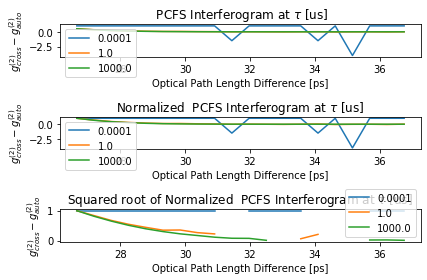

In [8]:
#%%
pcfs1.get_blinking_corrected_PCFS()

pcfs1.plot_spectral_diffusion([1e2,1e6,1e9], -4)
pcfs1.get_mirror_spectral_corr(0, 0)
pcfs1.get_splev_mirror_spec_corr( 0, 0)

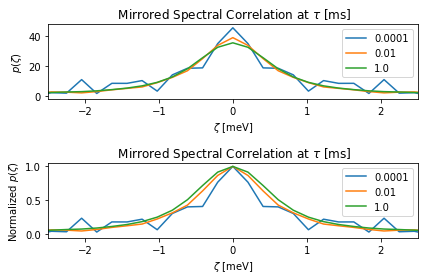

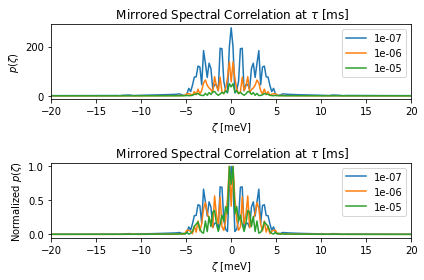

In [15]:
pcfs1.plot_splev_spec_corr([1e5,1e7,1e9],(-2.5,2.5))
pcfs1.plot_splev_spec_corr([1e2,1e3,1e4],(-20,20))



spectral_corr_file = directory + '_spectral_correlation_1e7,5e8_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'
zeta_file = directory + '_zeta_1e7,5e8_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'

# Save the data to text files
np.savetxt(spectral_corr_file, pcfs1.splev_spec_corr['spectral_corr'])
np.savetxt(zeta_file, pcfs1.splev_spec_corr['zeta'])


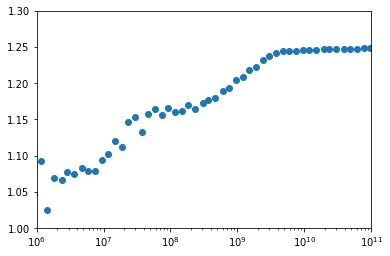

In [17]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
def lorenzian(x, x0, gamma, A):
    return A * (gamma / ((x - x0) ** 2 + gamma ** 2) / np.pi)

fwhm_arr = []
for i in range(len(pcfs1.tau)):
    y = pcfs1.splev_spec_corr['spectral_corr'][i,:]/max(pcfs1.splev_spec_corr['spectral_corr'][i,:])
    x = pcfs1.splev_spec_corr['zeta']
    try:
        params, covariance = curve_fit(lorenzian, x, y)
    except RuntimeError:
        fwhm_arr.append(0)
    else:
        #for lorenzian
        fwhm = 2 * params[1] 
        #for gaussian
        #fwhm = 2 * np.sqrt(2 * np.log(2)) * params[2]
        fwhm_arr.append(fwhm)
        #plt.plot(x, y, 'bo', label='Data')
        #plt.plot(x, lorenzian(x, *params), 'r-', label='Fit')
        #plt.xlim(-2.5,2.5)
        #plt.legend()
        
        #plt.show()

#%%
plt.scatter(pcfs1.tau,fwhm_arr, label='Scatter Plot on Log Scales')
plt.xscale('log')
#plt.xlim(1e4,1e11)
plt.ylim(1,1.3)
plt.xlim(1e6,1e11)
plt.show()
total_end = timing.time()
#print(f'total run time: {total_end-total_start}')



'''
FWHM_arr = []
for i in range(len(pcfs1.tau)):
    y = pcfs1.splev_spec_corr['spectral_corr'][i,:]/max(pcfs1.splev_spec_corr['spectral_corr'][i,:])
    x = pcfs1.splev_spec_corr['zeta']
    max_y = np.max(y)

    # Determine half-maximum value
    half_max_y = max_y / 2

    # Find the indices where y crosses half-maximum value
    above_half_max = y > half_max_y
    crossings = np.where(np.diff(above_half_max))[0]

    # Calculate FWHM
    if len(crossings) >= 2:
        # Get the x-values at the two crossing points
        x_crossings = x[crossings]

        # FWHM is the difference between the x-values at the two crossing points
        FWHM = np.abs(x_crossings[1] - x_crossings[0])
    else:
        # FWHM cannot be calculated
        FWHM = np.nan  # Assign NaN if FWHM cannot be determined
    FWHM_arr.append(FWHM)
    plt.plot(x,y)
    plt.xlim(-2.5,2.5)
    plt.show()
    print("FWHM:", FWHM)
    
plt.plot(pcfs1.tau,FWHM_arr)
plt.xscale('log')
plt.show()
'''
fwhm_file = directory + 'FWHM_1e7,5e8_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'
np.savetxt(fwhm_file,fwhm_arr)

In [ ]:




'''
Check to see if the widths match the spectral convolution by calculating the correlation of the diffused spectra and the undiffused spectra
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define Gaussian functions f(x) and g(x)
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

# Parameters for the Gaussian functions f(x) and g(x)
A_f = 1
mu_f = 0
sigma_f = std_dev

A_g = 1
mu_g = .5
sigma_g = std_dev

# Define the range and step size for x
x_min = -5
x_max = 5
delta_x = .01
x_values = np.arange(x_min, x_max, delta_x)

# Compute the values of f(x) and g(x)
f_x = gaussian(x_values, A_f, mu_f, sigma_f)
g_x = gaussian(x_values, A_g, mu_g, sigma_g)
g_x_neg = gaussian(x_values, A_g, -1*mu_g, sigma_g)
# Compute the cross-correlation
cross_corr_result = np.correlate(f_x, f_x, mode='same') * delta_x

# Fit the cross-correlation data to a Gaussian function
def fit_function(x, A, mu, sigma):
    return gaussian(x, A, mu, sigma)

popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Gaussian
A_fit, mu_fit, sigma_fit = popt

# Compute FWHM
FWHM1 = 2 * np.sqrt(2 * np.log(2)) * sigma_fit

# Compute standard deviation
std_deviation1 = sigma_fit

# Plot the original cross-correlation and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Gaussian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Gaussian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM undiffused:", FWHM1)
print("Standard deviation of the fitted Gaussian:", std_deviation1)


# Compute the cross-correlation
#you want to use 2fx+gx+gx_neg to get the time averaged spectra to work
cross_corr_result = np.correlate(f_x, 2*f_x+g_x+g_x_neg, mode='same') * delta_x

# Fit the cross-correlation data to a Gaussian function
def fit_function(x, A, mu, sigma):
    return gaussian(x, A, mu, sigma)

popt, pcov = curve_fit(fit_function, x_values, cross_corr_result, p0=[1, 0, 1])

# Extract parameters of the fitted Gaussian
A_fit, mu_fit, sigma_fit = popt

# Compute FWHM
FWHM2 = 2 * np.sqrt(2 * np.log(2)) * sigma_fit

# Compute standard deviation
std_deviation2 = sigma_fit

# Plot the original cross-correlation and the fitted Gaussian
plt.figure(figsize=(10, 5))
plt.plot(x_values, cross_corr_result, label='Cross-correlation', color='blue')
plt.plot(x_values, fit_function(x_values, *popt), label='Fitted Gaussian', color='red', linestyle='--')
plt.title('Cross-correlation and Fitted Gaussian')
plt.xlabel('x')
plt.ylabel('Cross-correlation')
plt.legend()
plt.grid(True)

plt.show()

print("FWHM diffused:", FWHM2)
print("Standard deviation of the fitted Gaussian:", std_deviation2)

print('% undiffused is',(100*(FWHM1/FWHM2)))
print('% undiffused is',(100*(std_deviation1/std_deviation2)))

horizontal_line = FWHM1/FWHM2  # You can change this to your desired value
# Create a scatter plot with logarithmic scales and open circles
plt.figure(figsize=(10, 6), dpi=600)  # Adjust the figure size and DPI as needed
fwhm_arr_norm = fwhm_arr/fwhm_arr[85]

scatter = plt.scatter(pcfs1.tau, fwhm_arr_norm, c='blue', marker='o', edgecolors='none',)
plt.xscale('log')
#plt.xlim(1e4, 1e11)
plt.ylim(0.5, 1.1)

# Labeling and titles with larger font sizes
plt.xlabel('Tau', fontsize=16,  color='black')
plt.ylabel(rf'FWHM of $P(\zeta)$', fontsize=16, color='black')
plt.title('Spectral Diffusion', fontsize=18, fontweight='bold',color='black')

# Remove gridlines
plt.grid(False)

# Customize ticks and tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)


plt.axhline(y=horizontal_line, color='red', linestyle='--',label = 'calculated from convolution')

scatter.set_sizes([50])
custom_dash = [10, 7]
plt.plot(pcfs1.tau, fwhm_arr_norm, linestyle=(0, (custom_dash[0], custom_dash[1])), color='black', linewidth=0.5, )
#plt.savefig(r"C:\Data and Code\Data\23_10_06_4ATPsimulations\Plots\my_plot.png", dpi=300)

plt.legend()

plt.show()
file_name_fwhm = directory + 'FWHM_ARR_1e7,1e9_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'
file_name_fwhmnorm = directory + 'FWHM_ARR_NORM_1e7,1e9_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'
file_name_tau = directory + 'Tau_1e7,1e9_switching_time_1,2cm_jumps_4cm_lorenz_linewidth'
np.savetxt(file_name_fwhm, fwhm_arr)
np.savetxt(file_name_fwhmnorm, fwhm_arr_norm)
np.savetxt(file_name_tau, pcfs1.tau)

In [ ]:
rmsd_arr = []
for k in range(10):
    log_bin = fwhm_arr_norm[(k*10):((k+1)*10)]
    mean_value = np.mean(log_bin)

    # Calculate the squared differences from the mean
    squared_diff = (log_bin - mean_value)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the RMSD by taking the square root of the mean squared difference
    rmsd = np.sqrt(mean_squared_diff)
    rmsd_arr.append(rmsd)
print(rmsd_arr)
plt.plot([10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],rmsd_arr)
plt.ylim(0,2)
plt.xscale('log')
plt.show()
#np.savetxt('/global/scratch/projects/co_utzatgroup/ccobbbruno/24_04_01_noise_approximations/photon_count'+f'{photon_number}',rmsd_arr)